In [1]:
import sys
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_theme(style="white")

# Mutation Insights

The objective of this notebook is to map mutation information to the GDSC database. In folder `knowledge_base/table_contents.md` it is described from where the Mutations and GDSC data is originating from. In the previous notebook `02_GDSC_map_GenExpr.ipynb` we mapped the GDSC data to gene-expression information. The resulting table is saved in `temp_datasets/joined_gdsc_geneexpr.pkl` which will be the starting point for this notebook.

In [2]:
!pwd
!find ../../datasets/gdsc/cell_line_genomic_data -name '*mutation*.csv' -ls

/Users/cwoest/Documents/Academics/Data_Science_UP/master_thesis/material/GNN-material
37667912  1489888 -rw-------    1 cwoest           staff            749603667 Mar 15 12:09 ../../datasets/gdsc/cell_line_genomic_data/mutations_all_20220315.csv
37707762     2376 -rw-------    1 cwoest           staff             1215200 Mar 15 11:59 ../../datasets/gdsc/cell_line_genomic_data/mutations_summary_20220315.csv


The files we will use for mapping are
- `mutations_all_20220315.csv`

In [2]:
PATH_TO_CNV_DATA = '../../datasets/gdsc/cell_line_genomic_data/'
PATH_TO_SAVE_DATA_TO = '../../datasets/gdsc/my_datasets/'

MUTATION_FILE = 'mutations_all_20220315.csv'

In [3]:
# First, we load the GDSC dataset from the previous notebook.
GDSC = pd.read_pickle(f'{PATH_TO_SAVE_DATA_TO}joined_gdsc_geneexpr.pkl')
print(GDSC.shape)
GDSC.head(3)

(446521, 922)


,DRUG_ID,CELL_LINE_NAME,AUC,CELL_ID,LN_IC50,CONC,MASTER_CELL_ID,INTENSITY,DATASET,Z_SCORE,...,MYCBP,FIS1,IFRD2,NPEPL1,CEBPD,PLEKHM1,MIF,PRAF2,LYN,POLG2
0,1,MC-CAR,0.982114,3137,2.395685,2.0,49,544404,GDSC1,-0.189576,...,8.355826,8.951680,7.205590,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
9,1,ES3,0.984816,2366,3.140923,2.0,1342,404197,GDSC1,0.508635,...,5.995760,9.337588,7.468226,3.716270,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
27,1,ES5,0.985693,2368,3.968757,2.0,610,797378,GDSC1,1.284229,...,6.939741,8.688176,7.085349,3.688222,4.572119,6.345090,12.276166,4.114092,5.768098,7.505155


In [12]:
GDSC.columns[:14]

Index(['DRUG_ID', 'CELL_LINE_NAME', 'AUC', 'CELL_ID', 'LN_IC50', 'CONC',
       'MASTER_CELL_ID', 'INTENSITY', 'DATASET', 'Z_SCORE', 'DRUG_NAME',
       'RMSE', 'COSMIC_ID', 'POSITION'],
      dtype='object')

--- 

## Mutations

In this subsection we will investigate and potentially map the `mutations_all_20220315.csv` content to the `GDSC` dataset.

The following is taken from [here](https://depmap.sanger.ac.uk/documentation/datasets/):

| Dataset Type | Description | Documentation |
| :----------- | :---------- | :------------ | 
| Mutation | All sequencing data including WES, WGS & TGS used to generate mutation data for the cell line and organoid models.	 | [Mutation](https://depmap.sanger.ac.uk/documentation/datasets/mutation/) |

In [4]:
MUTATION_FILE

'mutations_all_20220315.csv'

In [5]:
start = time.time()
mutations_all = pd.read_csv(f'{PATH_TO_CNV_DATA}{MUTATION_FILE}', sep=",", header=0)
print(f"File `{MUTATION_FILE}` took {time.time()-start:.5f} seconds to import. \nShape: {mutations_all.shape}")
mutations_all.head(10)

File `mutations_all_20220315.csv` took 13.89153 seconds to import. 
Shape: (8322616, 13)


,gene_id,gene_symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf,coding,source,model_name
0,SIDG36104,SOX30,SIDM02021,-,r.?,-,False,False,intronic,0.2703,False,Sanger,HCM-SANG-1082-C15
1,SIDG37647,THG1L,SIDM02021,-,r.?,-,False,False,intronic,0.7500,False,Sanger,HCM-SANG-1082-C15
2,SIDG16920,LSM11,SIDM02021,-,r.?,-,False,False,intronic,0.6452,False,Sanger,HCM-SANG-1082-C15
3,SIDG16920,LSM11,SIDM02021,p.?,r.3207delU,c.?,False,False,3prime_UTR_variant,0.7692,False,Sanger,HCM-SANG-1082-C15
4,SIDG16920,LSM11,SIDM02021,-,r.?,-,False,False,downstream,0.3571,False,Sanger,HCM-SANG-1082-C15
5,SIDG16920,LSM11,SIDM02021,-,r.?,-,False,False,downstream,0.7692,False,Sanger,HCM-SANG-1082-C15
6,SIDG04857,CLINT1,SIDM02021,-,r.?,-,False,False,downstream,0.4400,False,Sanger,HCM-SANG-1082-C15
7,SIDG04857,CLINT1,SIDM02021,-,r.?,-,False,False,intronic,0.3478,False,Sanger,HCM-SANG-1082-C15
8,SIDG04857,CLINT1,SIDM02021,-,r.?,-,False,False,intronic,0.3077,False,Sanger,HCM-SANG-1082-C15
9,SIDG04857,CLINT1,SIDM02021,-,r.?,-,False,False,intronic,0.3571,False,Sanger,HCM-SANG-1082-C15


In [6]:
start = time.time()
mutations_summary = pd.read_csv(f'{PATH_TO_CNV_DATA}mutations_summary_20220315.csv', sep=",", header=0)
print(f"File `mutations_summary_20220315.csv` took {time.time()-start:.5f} seconds to import. \nShape: {mutations_summary.shape}")
mutations_summary.head(10)

File `mutations_summary_20220315.csv` took 0.10022 seconds to import. 
Shape: (11609, 13)


,gene_id,gene_symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf,coding,source,model_name
0,SIDG13960,KRAS,SIDM01279,p.G12A,r.99g>c,c.35G>C,True,False,missense,0.5952,True,Sanger,HCM-SANG-0269-C18
1,SIDG01214,APC,SIDM01279,p.K1462*,r.4440a>u,c.4384A>T,True,False,nonsense,0.6757,True,Sanger,HCM-SANG-0269-C18
2,SIDG00920,AMER1,SIDM01279,p.W571*,r.1985g>a,c.1712G>A,True,False,nonsense,0.9714,True,Sanger,HCM-SANG-0269-C18
3,SIDG01764,ATM,SIDM01954,p.R1875*,r.6008c>u,c.5623C>T,True,False,nonsense,0.5000,True,Sanger,HCM-SANG-0537-C18
4,SIDG13960,KRAS,SIDM01954,p.G12S,r.98g>a,c.34G>A,True,False,missense,1.0000,True,Sanger,HCM-SANG-0537-C18
5,SIDG38363,TP53,SIDM01954,p.W91*,r.462g>a,c.272G>A,True,False,nonsense,1.0000,True,Sanger,HCM-SANG-0537-C18
6,SIDG24670,PIK3CA,SIDM01954,p.P104R,r.468c>g,c.311C>G,True,False,missense,0.4048,True,Sanger,HCM-SANG-0537-C18
7,SIDG38363,TP53,SIDM01277,p.E287_E294delENLRKKGE,r.1048_1071del24,c.858_881del24,True,False,inframe,1.0000,True,Sanger,HCM-SANG-0307-C15
8,SIDG16764,LRP1B,SIDM01277,p.T4475fs*3,r.14395_14396insa,c.13423_13424insA,True,False,frameshift,0.4872,True,Sanger,HCM-SANG-0307-C15
9,SIDG35070,SMAD4,SIDM01953,p.P293fs*10,r.1415_1428delCCUAUGCCGCCCCA,c.877_890delCCTATGCCGCCCCA,True,False,frameshift,1.0000,True,Sanger,HCM-SANG-0519-C20


In the mutations dataset we only have the `gene_symbol` but not the cell line name specifically as a column. However, we are given the `model_id`. This `model_id` can be mapped to the GDSC database to the column `SANGER_MODEL_ID` and from there the `CELL_LINE_NAME` can be infered. Thus, the steps to take are as follows: 
- [ ] Proof that the `SANGER_MODEL_ID` can 
  - [ ] be mapped to the `model_id`
  - [ ] has always one `CELL_LINE_NAME` (should be a 1-1 relationship, otherwise infering is not possible)
- [ ] Join the GDSC onto the mutations table and therefore infer the corresponding `CELL_LINE_NAME` per row (if given).

In [7]:
gdsc_gene_symbols = GDSC.columns[14:]
uniq_mut_all_gene_symbols = np.unique(mutations_all.gene_symbol).tolist()
uniq_mut_summary_gene_symbols = np.unique(mutations_summary.gene_symbol).tolist()

count_mut_all_gene_symbols_in_gdsc = sum(uniq_gene_symbol in gdsc_gene_symbols for uniq_gene_symbol in uniq_mut_all_gene_symbols)
mut_all_found_rate = round(100*count_mut_all_gene_symbols_in_gdsc/len(uniq_mut_all_gene_symbols), 2)

count_mut_summary_gene_symbols_in_gdsc = sum(uniq_gene_symbol in gdsc_gene_symbols for uniq_gene_symbol in uniq_mut_summary_gene_symbols)
mut_summary_found_rate = round(100*count_mut_summary_gene_symbols_in_gdsc/len(uniq_mut_summary_gene_symbols), 2)

print(f""" 
    Mutations All
        Out of {len(uniq_mut_all_gene_symbols)} unique Gene Symbols {count_mut_all_gene_symbols_in_gdsc} ({mut_all_found_rate}%) are also present in the {len(gdsc_gene_symbols)} GDSC gene symbol columns.

    Mutations Summary
        Out of {len(uniq_mut_summary_gene_symbols)} unique Gene Symbols {count_mut_summary_gene_symbols_in_gdsc} ({mut_summary_found_rate}%) are also present in the {len(gdsc_gene_symbols)} GDSC gene symbol columns. 
""")

 
    Mutations All
        Out of 23123 unique Gene Symbols 890 (3.85%) are also present in the 908 GDSC gene symbol columns.

    Mutations Summary
        Out of 611 unique Gene Symbols 83 (13.58%) are also present in the 908 GDSC gene symbol columns. 



Since the `Mutations Summary` dataset contains only mutations that were cancer drivers in the used models, we will continue with the `Mutations All` dataset only. The reason for that is to have also non-cancer driver information to let future models learn the difference. 

--- 

## Mutations All
In this section we will investigate the `mutations_all_20220315.csv` dataset only. 

In [8]:
mutations_all.head(5)

,gene_id,gene_symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf,coding,source,model_name
0,SIDG36104,SOX30,SIDM02021,-,r.?,-,False,False,intronic,0.2703,False,Sanger,HCM-SANG-1082-C15
1,SIDG37647,THG1L,SIDM02021,-,r.?,-,False,False,intronic,0.7500,False,Sanger,HCM-SANG-1082-C15
2,SIDG16920,LSM11,SIDM02021,-,r.?,-,False,False,intronic,0.6452,False,Sanger,HCM-SANG-1082-C15
3,SIDG16920,LSM11,SIDM02021,p.?,r.3207delU,c.?,False,False,3prime_UTR_variant,0.7692,False,Sanger,HCM-SANG-1082-C15
4,SIDG16920,LSM11,SIDM02021,-,r.?,-,False,False,downstream,0.3571,False,Sanger,HCM-SANG-1082-C15


- Column `gene_symbol` is again the column we can use to map to the `landmark_genes.csv` file to sparse down the set of genes.

__Problem__: We don't have cell-line information in the `Mutations All` dataset. 
- _Possible Solution_: Map the `model_id` of `mutations_all` to the `SANGER_MODEL_ID` of the GDSC IC50 dataset.

In [9]:
# Get the full GDSC database.

# GDSC IC50s.
gdsc1_ic50s = pd.read_excel('../../datasets/gdsc/screening_data/GDSC1_fitted_dose_response_25Feb20.xlsx', header=0)
gdsc2_ic50s = pd.read_excel('../../datasets/gdsc/screening_data/GDSC2_fitted_dose_response_25Feb20.xlsx', header=0)
gdsc_ic50s_join = pd.concat([gdsc1_ic50s, gdsc2_ic50s], ignore_index=True)

# GDSC raw. 
gdsc1_raw = pd.read_csv('../../datasets/gdsc/screening_data/GDSC1_public_raw_data_25Feb20.csv', header=0)
gdsc2_raw = pd.read_csv('../../datasets/gdsc/screening_data/GDSC2_public_raw_data_25Feb20.csv', header=0)
gdsc_raw_join = pd.concat([gdsc1_raw, gdsc2_raw], ignore_index=True)

# Join raw and ic50's.
cols_to_join_on = ['CELL_LINE_NAME', 'DRUG_ID']
gdsc_ic50_raw_join = gdsc_ic50s_join.merge(gdsc_raw_join,
                                           on=cols_to_join_on,
                                           how='left',
                                           suffixes=['_ic50', '_raw'])
print(gdsc_ic50_raw_join.shape)
gdsc_ic50_raw_join.head(5)

/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1662801193.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  gdsc1_raw = pd.read_csv('../../datasets/gdsc/screening_data/GDSC1_public_raw_data_25Feb20.csv', header=0)


(5707271, 35)


,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID_ic50,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,...,MASTER_CELL_ID,COSMIC_ID_raw,SEEDING_DENSITY,DRUGSET_ID,ASSAY,DURATION,POSITION,TAG,CONC,INTENSITY
0,GDSC1,281,12974350,683665,MC-CAR,SIDM00636,MM,1,Erlotinib,EGFR,...,49,683665,NaN,410_a_9,s,3.0,14,L1-D1-S,2.000,544404
1,GDSC1,281,12974350,683665,MC-CAR,SIDM00636,MM,1,Erlotinib,EGFR,...,49,683665,NaN,410_a_9,s,3.0,15,L1-D2-S,1.000,599897
2,GDSC1,281,12974350,683665,MC-CAR,SIDM00636,MM,1,Erlotinib,EGFR,...,49,683665,NaN,410_a_9,s,3.0,16,L1-D3-S,0.500,587627
3,GDSC1,281,12974350,683665,MC-CAR,SIDM00636,MM,1,Erlotinib,EGFR,...,49,683665,NaN,410_a_9,s,3.0,17,L1-D4-S,0.250,597272
4,GDSC1,281,12974350,683665,MC-CAR,SIDM00636,MM,1,Erlotinib,EGFR,...,49,683665,NaN,410_a_9,s,3.0,18,L1-D5-S,0.125,594490


In [28]:
gdsc_ic50_raw_join.columns

Index(['DATASET', 'NLME_RESULT_ID', 'NLME_CURVE_ID', 'COSMIC_ID_ic50',
       'CELL_LINE_NAME', 'SANGER_MODEL_ID', 'TCGA_DESC', 'DRUG_ID',
       'DRUG_NAME', 'PUTATIVE_TARGET', 'PATHWAY_NAME', 'COMPANY_ID',
       'WEBRELEASE', 'MIN_CONC', 'MAX_CONC', 'LN_IC50', 'AUC', 'RMSE',
       'Z_SCORE', 'RESEARCH_PROJECT', 'BARCODE', 'SCAN_ID', 'DATE_CREATED',
       'SCAN_DATE', 'CELL_ID', 'MASTER_CELL_ID', 'COSMIC_ID_raw',
       'SEEDING_DENSITY', 'DRUGSET_ID', 'ASSAY', 'DURATION', 'POSITION', 'TAG',
       'CONC', 'INTENSITY'],
      dtype='object')

- First, we need to check which columns have a 1-to-1 relationship to the cell-line name. 

The following three have a 1-to-1 relationship to each other.
```
    CELL_LINE_NAME 
    MASTER_CELL_ID
    COSMIC_ID
```
However, none of these are present in the `Mutations All` dataset.

In [38]:
uniq_sanger_model_ids__gdsc = np.unique(gdsc_ic50_raw_join.SANGER_MODEL_ID).tolist()
uniq_model_ids__mutations = np.unique(mutations_all.model_id).tolist()

In [48]:
# Check which of the SANGER_MODEL_ID's are also present in the mutations dataset.
not_present = set(uniq_sanger_model_ids__gdsc) - set(uniq_model_ids__mutations)
present = set(uniq_sanger_model_ids__gdsc) - not_present
print(f"""Out of {len(uniq_sanger_model_ids__gdsc)} unique SANGER_MODEL_ID's in the GDSC table 
       {len(present)} ({round(100*len(present)/len(uniq_sanger_model_ids__gdsc), 2)} %) are also present under column `model_id` in the `Mutations All` table.""")

Out of 988 unique SANGER_MODEL_ID's in the GDSC table 
       983 (99.49 %) are also present under column `model_id` in the `Mutations All` table.


In [79]:
# Find the CELL_LINE_NAME's per SANGER_MODEL_ID.
celllines_per_sangermodelid = gdsc_ic50_raw_join[['SANGER_MODEL_ID', 'CELL_LINE_NAME']].groupby('SANGER_MODEL_ID')['CELL_LINE_NAME'].nunique()
counts_per_sangermodelid = celllines_per_sangermodelid.values

assert (counts_per_sangermodelid != 1).any() == False
assert (counts_per_sangermodelid == 1).all()

__Note__: We validated that each `SANGER_MODEL_ID` has always only one `CELL_LINE_NAME`. Thus,
> `SANGER_MODEL_ID` and `CELL_LINE_NAME` have a 1-to-1 relationship.

__Conclusion__: If we map the GDSC table to the `Mutations All` table based on `SANGER_MODEL_ID` and `model_id` respectively, and include the `CELL_LINE_NAME` as well, we then have for each `gene_symbol` in the `Mutations All` table a corresponding cell-line name. 

### Map GDSC to Mutations All

Based on the previous sections analysis we can map the `SANGER_MODEL_ID` from the GDSC table to the `model_id` from the `Mutations All` table.

In [10]:
mutations_all.head(3)

,gene_id,gene_symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf,coding,source,model_name
0,SIDG36104,SOX30,SIDM02021,-,r.?,-,False,False,intronic,0.2703,False,Sanger,HCM-SANG-1082-C15
1,SIDG37647,THG1L,SIDM02021,-,r.?,-,False,False,intronic,0.7500,False,Sanger,HCM-SANG-1082-C15
2,SIDG16920,LSM11,SIDM02021,-,r.?,-,False,False,intronic,0.6452,False,Sanger,HCM-SANG-1082-C15


In [13]:
# Only take the interested columns for the mapping.
gdsc_mapping_subset = gdsc_ic50_raw_join[['SANGER_MODEL_ID', 'CELL_LINE_NAME']]

# Only take the unique SANGER_MODEL_ID's, since these have a 1-to-1 relationship to the CELL_LINE_NAME's anyways.
gdsc_mapping_subset = gdsc_mapping_subset.groupby('SANGER_MODEL_ID').first().reset_index(level=0)
gdsc_mapping_subset.head(3)

,SANGER_MODEL_ID,CELL_LINE_NAME
0,SIDM00003,M14
1,SIDM00023,TE-12
2,SIDM00040,TMK-1


In [14]:
# Join the CELL_LINE_NAME's onto the mutations_all dataset, based on the model_id.
mutations_all_v2 = mutations_all.merge(gdsc_mapping_subset,
                                       left_on='model_id',
                                       right_on='SANGER_MODEL_ID',
                                       how='left')
print(mutations_all_v2.shape)
mutations_all_v2.head(5)

(8322616, 15)


,gene_id,gene_symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf,coding,source,model_name,SANGER_MODEL_ID,CELL_LINE_NAME
0,SIDG36104,SOX30,SIDM02021,-,r.?,-,False,False,intronic,0.2703,False,Sanger,HCM-SANG-1082-C15,NaN,NaN
1,SIDG37647,THG1L,SIDM02021,-,r.?,-,False,False,intronic,0.7500,False,Sanger,HCM-SANG-1082-C15,NaN,NaN
2,SIDG16920,LSM11,SIDM02021,-,r.?,-,False,False,intronic,0.6452,False,Sanger,HCM-SANG-1082-C15,NaN,NaN
3,SIDG16920,LSM11,SIDM02021,p.?,r.3207delU,c.?,False,False,3prime_UTR_variant,0.7692,False,Sanger,HCM-SANG-1082-C15,NaN,NaN
4,SIDG16920,LSM11,SIDM02021,-,r.?,-,False,False,downstream,0.3571,False,Sanger,HCM-SANG-1082-C15,NaN,NaN


In [16]:
 # Only taking the once with a CELL_LINE_NAME.
mutations_all_v3 = mutations_all_v2[mutations_all_v2['CELL_LINE_NAME'].notna()]
print(mutations_all_v3.shape)
mutations_all_v3.head(5)

(4574963, 15)


,gene_id,gene_symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf,coding,source,model_name,SANGER_MODEL_ID,CELL_LINE_NAME
19,SIDG40054,UAP1,SIDM00615,-,r.?,-,False,False,intronic,0.2857,False,Sanger,JHH-6,SIDM00615,JHH-6
20,SIDG13175,IPO11,SIDM01119,-,r.?,-,False,False,intronic,0.3511,False,Sanger,NCI-H727,SIDM01119,NCI-H727
21,SIDG14638,LIN9,SIDM00933,-,r.?,-,False,False,downstream,1.0000,False,Sanger,CAL-51,SIDM00933,CAL-51
22,SIDG07173,DYM,SIDM00933,-,r.?,-,False,False,intronic,0.5294,False,Sanger,CAL-51,SIDM00933,CAL-51
23,SIDG08926,FCAMR,SIDM00620,-,r.?,-,False,False,intronic,0.6250,False,Sanger,D-336MG,SIDM00620,D-336MG


### Sparse Down Via Landmark Genes

Now we sparse down the rows by only including the `gene_symbols` which are also been found in the `landmark_genes.csv` file.

In [18]:
print(f"Number of unique `gene_symbol`s in the mutations dataset: {len(np.unique(mutations_all_v3.gene_symbol))}")

Number of unique `gene_symbol`s in the mutations dataset: 20450


In [19]:
PATH_TO_GDSC_DATASETS = '../../datasets/gdsc/'
FILENAME_LANDMARK_GENES = 'landmark_genes.csv' 

start = time.time()
landmark_genes = pd.read_csv(f'{PATH_TO_GDSC_DATASETS}{FILENAME_LANDMARK_GENES}', sep="\t")
print(f"File `{FILENAME_LANDMARK_GENES}` took {time.time()-start:.5f} seconds to import. It has shape {landmark_genes.shape}")
landmark_genes.head(3)

File `landmark_genes.csv` took 0.07569 seconds to import. It has shape (978, 7)


,Entrez ID,Symbol,Name,Gene Family,Type,RNA-Seq Correlation,RNA-Seq Correlation Self-Rank
0,3638,INSIG1,insulin induced gene 1,NaN,landmark,NaN,NaN
1,2309,FOXO3,forkhead box O3,Forkhead boxes,landmark,NaN,NaN
2,1001,CDH3,cadherin 3,Type I classical cadherins,landmark,NaN,NaN


In [20]:
landmark_genes_v2 = landmark_genes['Symbol']

In [21]:
# Take only the rows which have a `gene_symbol` which is also present in the landmark genes table.
mutations_all_v4 = mutations_all_v3.merge(landmark_genes_v2,
                                          left_on='gene_symbol',
                                          right_on='Symbol')
print(mutations_all_v4.shape)
mutations_all_v4.head(3)                                          

(235906, 16)


,gene_id,gene_symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf,coding,source,model_name,SANGER_MODEL_ID,CELL_LINE_NAME,Symbol
0,SIDG40702,VGLL4,SIDM00330,-,r.?,-,False,False,intronic,0.9926,False,Sanger,LAN-6,SIDM00330,LAN-6,VGLL4
1,SIDG40702,VGLL4,SIDM00944,p.?,r.407-7c>u,c.?,False,False,splice_region,0.6190,False,Broad,CL-11,SIDM00944,CL-11,VGLL4
2,SIDG40702,VGLL4,SIDM00373,p.?,r.65c>u,c.?,False,False,5prime_UTR_variant,0.4118,False,Broad,SNG-M,SIDM00373,SNG-M,VGLL4


In [22]:
# How many unique genes are there per cell-line?
uniq_genes_per_cellline =  mutations_all_v4[['gene_symbol', 'CELL_LINE_NAME']].groupby('CELL_LINE_NAME')['gene_symbol'].nunique()
uniq_genes_per_cellline

CELL_LINE_NAME
22RV1       297
23132-87    252
42-MG-BA     80
451Lu        79
5637        279
           ... 
YT          196
ZR-75-30    337
huH-1       202
no-10       191
no-11       181
Name: gene_symbol, Length: 983, dtype: int64

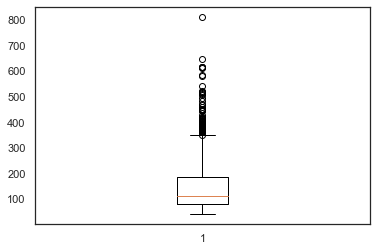

In [24]:
plt.boxplot(uniq_genes_per_cellline);

In [26]:
mutations_all_v5 = mutations_all_v4[[
    'CELL_LINE_NAME',
    'gene_symbol',
    'model_id',
    'protein_mutation',
    'rna_mutation',
    'cdna_mutation',
    'cancer_driver',
    'vaf'
]]
print(mutations_all_v5.shape)
mutations_all_v5.head(5)

(235906, 8)


,CELL_LINE_NAME,gene_symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,vaf
0,LAN-6,VGLL4,SIDM00330,-,r.?,-,False,0.9926
1,CL-11,VGLL4,SIDM00944,p.?,r.407-7c>u,c.?,False,0.6190
2,SNG-M,VGLL4,SIDM00373,p.?,r.65c>u,c.?,False,0.4118
3,JHOS-2,VGLL4,SIDM00305,-,r.?,-,False,0.5698
4,NCI-H1436,VGLL4,SIDM00697,-,r.?,-,False,0.9677


The final dataset contains for now still the `gene_symbol` as a column and not each gene as a separate column. Previous notebooks contained the cell-lines as rows and the genes as columns. However, since we have here 
- protein_mutation
- rna_mutation
- cdna_mutation
as information columns regarding the mutation we would need to create 3 different table. Each table would hold for the `(CELL_LINE_NAME_i, gene_symbol_column_j)` cell either the protein, the rna or the cdna mutation value respectively.

In [27]:
mutations_all_v5.to_pickle(f'{PATH_TO_SAVE_DATA_TO}joined_gdsc_mutations.pkl')

## Create Table Per Mutation Information

In this subsection we will create a 2d table per mutation data: 
- protein_mutation
- rna_mutation
- cdna_mutation


In [34]:
mutations_all_v5 = pd.read_pickle(f'{PATH_TO_SAVE_DATA_TO}joined_gdsc_mutations.pkl')
uniq_mutation_genes = np.unique(mutations_all_v5.gene_symbol)
print(f"Unique number of `gene_symbol`'s: {len(uniq_mutation_genes)}")

Unique number of `gene_symbol`'s: 956


### Protein Mutation

In [56]:
mutations_all_protein = mutations_all_v5[['CELL_LINE_NAME', 'gene_symbol', 'protein_mutation']]
mutations_all_protein.head(20)

,CELL_LINE_NAME,gene_symbol,protein_mutation
0,LAN-6,VGLL4,-
1,CL-11,VGLL4,p.?
2,SNG-M,VGLL4,p.?
3,JHOS-2,VGLL4,-
4,NCI-H1436,VGLL4,-
5,HCC1395,VGLL4,-
6,SNU-175,VGLL4,-
7,CL-40,VGLL4,p.?
8,TOV-21G,VGLL4,p.?
9,Hep3B2-1-7,VGLL4,-


In [39]:
mutations_all_protein.loc[mutations_all_protein['gene_symbol'] == 'VGLL4', 'protein_mutation']

0            -
1          p.?
2          p.?
3            -
4            -
        ...   
251          -
252          -
253    p.M119V
254          -
255          -
Name: protein_mutation, Length: 256, dtype: object

In [57]:
# Add the mutation values for each gene as a new column.
current_max = 3
for i, uniq_gene in enumerate(uniq_mutation_genes): 
    print(f"Appending {uniq_gene}...")
    mutations_all_protein.insert(current_max+i, 
                                 uniq_gene, 
                                 mutations_all_protein.where(mutations_all_protein['gene_symbol'] == uniq_gene)['protein_mutation'].values)


Appending ABCB6...
Appending ABCC5...
Appending ABCF1...
Appending ABCF3...
Appending ABHD4...
Appending ABHD6...
Appending ABL1...
Appending ACAA1...
Appending ACAT2...
Appending ACBD3...
Appending ACD...
Appending ACLY...
Appending ACOT9...
Appending ADAM10...
Appending ADAT1...
Appending ADGRE5...
Appending ADGRG1...
Appending ADH5...
Appending ADI1...
Appending ADO...
Appending ADRB2...
Appending AGL...
Appending AKAP8...
Appending AKAP8L...
Appending AKR7A2...
Appending AKT1...
Appending ALAS1...
Appending ALDH7A1...
Appending ALDOA...
Appending ALDOC...
Appending AMDHD2...
Appending ANKRD10...
Appending ANO10...
Appending ANXA7...
Appending APBB2...
Appending APOE...
Appending APP...
Appending APPBP2...
Appending ARFIP2...
Appending ARHGAP1...
Appending ARHGEF12...
Appending ARHGEF2...
Appending ARID4B...
Appending ARID5B...
Appending ARL4C...
Appending ARNT2...
Appending ARPP19...
Appending ASAH1...
Appending ASCC3...
Appending ATF1...
Appending ATF5...
Appending ATF6...
Appendi

/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CASP10...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CASP2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CASP3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CASP7...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CAST...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CAT...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CBLB...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CBR1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CBR3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CCDC85B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CCDC86...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CCDC92...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CCL2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CCNA1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CCNA2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CCNB1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CCNB2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CCND1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CCND3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CCNE2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CCNF...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CCNH...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CCP110...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CD320...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CD40...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CD44...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CD58...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CDC20...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CDC25A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CDC25B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CDC42...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CDC45...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CDCA4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CDH3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CDK1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CDK19...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CDK2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CDK4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CDK5R1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CDK6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CDK7...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CDKN1A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CDKN1B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CDKN2A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CEBPA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CEBPD...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CEBPZ...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CENPE...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CEP57...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CERK...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CETN3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CFLAR...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CGRRF1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CHAC1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CHEK1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CHEK2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CHERP...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CHIC2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CHMP4A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CHMP6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CHN1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CHP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CIAPIN1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CIRBP...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CISD1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CLIC4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CLPX...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CLSTN1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CLTB...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CLTC...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CNDP2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CNOT4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CNPY3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending COASY...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending COG2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending COG4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending COG7...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending COL1A1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending COL4A1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending COPB2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending COPS7A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending COQ8A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CORO1A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CPNE3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CPSF4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CREB1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CREG1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CRELD2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CRK...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CRKL...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CRTAP...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CRYZ...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CSK...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CSNK1A1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CSNK1E...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CSNK2A2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CSRP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CTNNAL1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CTNND1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CTSD...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CTSL...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CTTN...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CXCL2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CXCR4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CYB561...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CYCS...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending CYTH1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DAG1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DAXX...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DCK...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DCTD...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DCUN1D4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DDB2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DDIT4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DDR1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DDX10...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DDX42...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DECR1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DENND2D...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DERA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DFFA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DFFB...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DHDDS...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DHRS7...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DHX29...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DLD...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DMTF1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DNAJA3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DNAJB1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DNAJB2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DNAJB6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DNAJC15...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DNM1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DNM1L...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DNMT1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DNMT3A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DNTTIP2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DPH2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DRAP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DSG2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DUSP11...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DUSP14...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DUSP22...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DUSP3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DUSP4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DUSP6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DYNLT3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending DYRK3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending E2F2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EAPP...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EBNA1BP2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EBP...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ECD...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ECH1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EDEM1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EDN1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EED...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EFCAB14...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EGF...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EGFR...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EGR1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EIF4EBP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EIF4G1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EIF5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ELAC2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ELAVL1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ELOVL6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EML3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ENOPH1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ENOSF1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EPB41L2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EPHA3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EPHB2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EPN2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ERBB2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ERBB3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ERO1A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ETFB...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ETS1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ETV1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EVL...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EXOSC4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EXT1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending EZH2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FAH...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FAIM...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FAM20B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FAS...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FASTKD5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FAT1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FBXL12...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FBXO11...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FBXO21...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FBXO7...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FCHO1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FDFT1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FEZ2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FGFR2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FGFR4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FHL2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FIS1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FKBP14...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FKBP4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FOS...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FOSL1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FOXJ3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FOXO3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FOXO4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FPGS...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FRS2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FSD1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FUT1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FYN...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FZD1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending FZD7...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending G3BP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GAA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GABPB1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GADD45A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GADD45B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GALE...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GAPDH...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GATA2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GATA3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GDPD5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GFOD1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GFPT1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GHR...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GLI2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GLOD4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GLRX...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GMNN...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GNA11...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GNA15...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GNAI1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GNAI2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GNAS...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GNB5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GNPDA1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GOLT1B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GPATCH8...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GPC1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GPER1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GRB10...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GRB7...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GRN...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GRWD1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GSTM2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GSTZ1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GTF2A2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GTF2E2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending GTPBP8...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HACD3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HADH...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HAT1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HDAC2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HDAC6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HEATR1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HEBP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HERC6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HERPUD1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HES1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HIF1A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HK1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HLA-DMA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HLA-DRA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HMG20B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HMGA2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HMGCR...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HMGCS1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HMOX1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HOMER2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HOOK2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HOXA10...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HOXA5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HPRT1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HS2ST1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HSD17B10...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HSD17B11...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HSPA1A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HSPA4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HSPA8...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HSPB1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HSPD1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HTATSF1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HTRA1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending HYOU1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending IARS2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ICAM1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ICAM3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ICMT...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ID2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending IDE...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending IER3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending IFNAR1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending IFRD2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending IGF1R...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending IGF2BP2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending IGF2R...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending IGFBP3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending IGHMBP2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending IKBKB...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending IKBKE...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending IKZF1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending IL13RA1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending IL1B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending IL4R...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ILK...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending INPP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending INPP4B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending INSIG1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending INTS3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending IPO13...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending IQGAP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ISOC1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ITFG1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ITGAE...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ITGB1BP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ITGB5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending JADE2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending JMJD6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending JUN...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KAT6A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KAT6B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KCNK1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KCTD5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KDELR2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KDM3A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KDM5A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KDM5B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KEAP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KIAA0100...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KIAA0753...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KIF14...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KIF20A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KIF2C...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KIF5C...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KIT...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KLHDC2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KLHL21...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KLHL9...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending KTN1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LAGE3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LAMA3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LAP3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LBR...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LGALS8...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LGMN...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LIG1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LIPA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LOXL1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LPAR2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LPGAT1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LRP10...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LRPAP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LRRC41...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LSM5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LSM6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LSR...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LYN...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LYPLA1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending LYRM1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MACF1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MALT1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MAMLD1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MAN2B1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MAP2K5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MAP3K4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MAP4K4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MAP7...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MAPK13...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MAPK1IP1L...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MAPK9...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MAPKAPK2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MAPKAPK3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MAPKAPK5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MAST2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MAT2A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MBNL1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MBNL2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MBOAT7...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MBTPS1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MCM3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MCOLN1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MCUR1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ME2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MEF2C...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MELK...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MEST...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending METRN...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MFSD10...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MICALL1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MIF...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MINDY1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MKNK1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MLEC...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MLLT11...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MMP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MMP2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MNAT1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MOK...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MPC2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MPZL1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MRPL12...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MRPL19...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MRPS16...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MRPS2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MSH6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MSRA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MTA1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MTERF3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MTF2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MTFR1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MTHFD2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MUC1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MVP...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MYBL2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MYC...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MYCBP...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MYCBP2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MYL9...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MYLK...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending MYO10...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NCAPD2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NCK1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NCK2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NCOA3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NENF...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NET1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NFATC3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NFATC4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NFE2L2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NFIL3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NFKB2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NFKBIA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NFKBIB...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NFKBIE...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NGRN...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NIPSNAP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NISCH...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NIT1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NMT1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NNT...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NOL3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NOLC1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NOS3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NOSIP...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NOTCH1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NPC1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NPDC1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NPEPL1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NPRL2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NR1H2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NR2F6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NR3C1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NRAS...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NRIP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NSDHL...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NT5DC2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NUCB2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NUDCD3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NUDT9...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NUP133...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NUP62...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NUP85...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NUP88...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NUP93...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NUSAP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending NVL...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ORC1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending OXA1L...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending OXCT1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending OXSR1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending P4HA2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending P4HTM...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PACSIN3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PAF1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PAFAH1B1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PAFAH1B3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PAICS...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PAK1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PAK4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PAK6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PAN2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PARP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PARP2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PAX8...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PCBD1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PCCB...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PCK2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PCM1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PCMT1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PCNA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PDGFA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PDHX...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PDIA5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PDLIM1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PDS5A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PECR...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PEX11A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PFKL...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PGAM1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PGM1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PGRMC1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PHGDH...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PHKA1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PHKB...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PHKG2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PIGB...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PIH1D1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PIK3C2B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PIK3C3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PIK3CA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PIK3R3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PIK3R4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PIN1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PIP4K2B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PKIG...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PLA2G15...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PLA2G4A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PLCB3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PLEKHJ1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PLEKHM1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PLK1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PLOD3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PLP2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PLS1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PLSCR1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PLSCR3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PMAIP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PMM2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PNKP...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PNP...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending POLB...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending POLD4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending POLE2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending POLG2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending POLR1C...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending POLR2I...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending POLR2K...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending POP4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PPARD...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PPARG...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PPIC...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PPIE...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PPOX...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PPP1R13B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PPP2R3C...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PPP2R5A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PPP2R5E...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PRAF2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PRCP...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PRKACA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PRKAG2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PRKCD...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PRKCH...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PRKCQ...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PRKX...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PROS1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PRPF4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PRR15L...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PRR7...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PRSS23...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PRUNE1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PSIP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PSMB10...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PSMB8...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PSMD10...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PSMD2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PSMD4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PSMD9...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PSME1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PSME2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PSMF1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PSMG1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PSRC1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PTGS2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PTK2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PTK2B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PTPN1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PTPN12...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PTPN6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PTPRC...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PTPRF...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PTPRK...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PUF60...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PWP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PXMP2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PXN...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PYCR1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending PYGL...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RAB11FIP2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RAB21...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RAB27A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RAB31...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RAB4A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RAC2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RAD51C...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RAD9A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RAE1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RAI14...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RALA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RALB...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RALGDS...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RAP1GAP...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RASA1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RB1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RBKS...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RBM15B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RBM34...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RBM6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending REEP5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RELB...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RFC2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RFC5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RFNG...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RFX5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RGS2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RHEB...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RHOA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RNF167...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RNH1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RNMT...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RNPS1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RPA1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RPA2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RPA3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RPIA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RPL39L...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RPN1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RPP38...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RPS5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RPS6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RPS6KA1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RRAGA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RRP12...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RRP1B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RRP8...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RRS1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RSU1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RTN2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending RUVBL1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending S100A13...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending S100A4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SACM1L...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SATB1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SCAND1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SCARB1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SCCPDH...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SCP2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SCRN1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SCYL3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SDHB...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SENP6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SERPINE1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SESN1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SFN...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SGCB...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SH3BP5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SHB...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SHC1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SIRT3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SKIV2L...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SKP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SLC11A2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SLC1A4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SLC25A13...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SLC25A14...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SLC25A4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SLC25A46...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SLC27A3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SLC2A6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SLC35A1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SLC35A3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SLC35B1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SLC35F2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SLC37A4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SLC5A6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SMAD3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SMARCA4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SMARCC1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SMARCD2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SMC1A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SMC3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SMC4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SMNDC1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SNAP25...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SNCA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SNX11...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SNX13...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SNX6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SNX7...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SOCS2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SORBS3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SOX2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SOX4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SPAG4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SPAG7...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SPDEF...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SPEN...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SPP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SPR...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SPRED2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SPTAN1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SPTLC2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SQSTM1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SRC...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SSBP2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ST3GAL5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ST6GALNAC2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ST7...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending STAMBP...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending STAP2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending STAT1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending STAT3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending STAT5B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending STK10...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending STK25...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending STMN1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending STUB1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending STX1A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending STX4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending STXBP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending STXBP2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SUPV3L1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SUV39H1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SUZ12...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SYK...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SYNE2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SYNGR3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending SYPL1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TARBP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TATDN2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TBC1D31...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TBC1D9B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TBP...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TBPL1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TBX2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TBXA2R...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TCEA2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TCEAL4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TCERG1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TCFL5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TCTA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TCTN1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TERF2IP...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TERT...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TES...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TESK1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TEX10...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TFAP2A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TFDP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TGFB3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TGFBR2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending THAP11...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TIAM1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TICAM1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TIMELESS...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TIMM17B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TIMM22...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TIMM9...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TIMP2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TIPARP...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TJP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TLE1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TLK2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TLR4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TM9SF2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TM9SF3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TMCO1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TMED10...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TMEM109...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TMEM50A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TMEM97...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TNFRSF21...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TNIP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TOMM34...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TOMM70...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TOP2A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TOPBP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TOR1A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TP53...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TP53BP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TP53BP2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TPD52L2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TPM1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TRAK2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TRAM2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TRAP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TRAPPC3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TRAPPC6A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TRIB1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TRIB3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TRIM13...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TRIM2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TSC22D3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TSEN2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TSKU...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TSPAN3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TSPAN4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TSPAN6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TUBB6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TWF2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TXLNA...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TXNDC9...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TXNL4B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending TXNRD1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending UBE2A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending UBE2C...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending UBE2J1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending UBE2L6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending UBE3B...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending UBE3C...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending UBQLN2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending UBR7...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending UFM1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending UGDH...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending USP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending USP14...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending USP22...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending USP6NL...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending USP7...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending UTP14A...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending VAPB...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending VAT1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending VAV3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending VDAC1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending VGLL4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending VPS28...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending VPS72...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending WASF3...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending WASHC4...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending WASHC5...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending WDR61...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending WDR7...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending WDTC1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending WFS1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending WIPF2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending XBP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending XPNPEP1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending XPO7...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending YKT6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending YME1L1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending YTHDF1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ZDHHC6...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ZFP36...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ZMIZ1...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ZMYM2...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ZNF131...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ZNF274...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ZNF318...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ZNF395...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ZNF451...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ZNF586...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ZNF589...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


Appending ZW10...


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_42080/1574832305.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mutations_all_protein.insert(current_max+i,


In [58]:
mutations_all_protein.head(20)

,CELL_LINE_NAME,gene_symbol,protein_mutation,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,LAN-6,VGLL4,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CL-11,VGLL4,p.?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SNG-M,VGLL4,p.?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,JHOS-2,VGLL4,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NCI-H1436,VGLL4,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,HCC1395,VGLL4,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,SNU-175,VGLL4,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,CL-40,VGLL4,p.?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,TOV-21G,VGLL4,p.?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Hep3B2-1-7,VGLL4,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### RNA Mutation

In [32]:
mutations_all_rna = mutations_all_v5[['CELL_LINE_NAME', 'gene_symbol', 'rna_mutation']]
mutations_all_rna.head(5)

,CELL_LINE_NAME,gene_symbol,rna_mutation
0,LAN-6,VGLL4,r.?
1,CL-11,VGLL4,r.407-7c>u
2,SNG-M,VGLL4,r.65c>u
3,JHOS-2,VGLL4,r.?
4,NCI-H1436,VGLL4,r.?


### CDNA Mutation

In [33]:
mutations_all_cdna = mutations_all_v5[['CELL_LINE_NAME', 'gene_symbol', 'cdna_mutation']]
mutations_all_cdna.head(5)

,CELL_LINE_NAME,gene_symbol,cdna_mutation
0,LAN-6,VGLL4,-
1,CL-11,VGLL4,c.?
2,SNG-M,VGLL4,c.?
3,JHOS-2,VGLL4,-
4,NCI-H1436,VGLL4,-


In [39]:
len(uniq_sanger_model_ids__gdsc)

988

In [40]:
len(uniq_model_ids__mutations)

1385

In [30]:
# The following script is to obtain the type of relationship between two columns.
# Adapted from https://stackoverflow.com/questions/59091196/checking-the-type-of-relationship-between-columns-in-python-pandas-one-to-one 

def get_relation(df, col_1, col_2):        
    first_max = df[[col_1, col_2]].groupby(col_1).count().max()[0]
    second_max = df[[col_1, col_2]].groupby(col_2).count().max()[0]
    if first_max==1:
        return '1-to-1' if second_max==1 else '1-to-n'
    else:
        return 'n-to-1' if second_max==1 else 'n-to-n'

In [34]:
from itertools import product

# Subset of dataset which should be checked for its relationship of its columns to each other.
subset_cols = [
    'CELL_LINE_NAME',
    'MASTER_CELL_ID',
    'COSMIC_ID_ic50',
    'SANGER_MODEL_ID'
]
subset = gdsc_ic50_raw_join[subset_cols]

for col_i, col_j in product(subset.columns, subset.columns):
    if col_i == col_j:
        continue
    print(f"{col_i} : {col_j} --> {get_relation(gdsc_ic50_raw_join, col_i, col_j)}")

CELL_LINE_NAME : MASTER_CELL_ID --> n-to-n
CELL_LINE_NAME : COSMIC_ID_ic50 --> n-to-n
CELL_LINE_NAME : SANGER_MODEL_ID --> n-to-n
MASTER_CELL_ID : CELL_LINE_NAME --> n-to-n
MASTER_CELL_ID : COSMIC_ID_ic50 --> n-to-n
MASTER_CELL_ID : SANGER_MODEL_ID --> n-to-n
COSMIC_ID_ic50 : CELL_LINE_NAME --> n-to-n
COSMIC_ID_ic50 : MASTER_CELL_ID --> n-to-n
COSMIC_ID_ic50 : SANGER_MODEL_ID --> n-to-n
SANGER_MODEL_ID : CELL_LINE_NAME --> n-to-n
SANGER_MODEL_ID : MASTER_CELL_ID --> n-to-n
SANGER_MODEL_ID : COSMIC_ID_ic50 --> n-to-n


In [44]:
# Proof that the SANGER_MODEL_ID can be mapped to the model_id.
test = gdsc_ic50_raw_join.merge(mutations_summary,
                                right_on='model_id',
                                left_on='SANGER_MODEL_ID',
                                how='inner',
                                suffixes=['_gdsc', '_mut'])
print(f"""
    GDSC : {gdsc_ic50_raw_join.shape}
    mut  : {mutations_summary.shape}

    inner : {test.shape}
""")


    GDSC : (5707271, 35)
    mut  : (11609, 13)

    inner : (53359867, 48)



In [63]:
sangers = set(np.unique(gdsc_ic50_raw_join.SANGER_MODEL_ID)) 
model_ids = set(np.unique(mutations_summary.model_id))
print(f"""Unique
    SANGER_MDEL_ID's : {len(sangers):5.0f} (GDSC table)
    model_id's       : {len(model_ids):5.0f} (Mutations table)
""")

unequal = len(list(sangers - model_ids))
equal = len(sangers) - unequal
print(f"""
There are {unequal} ({100*unequal/len(sangers):2.2f}%) SANGER_MODEL_ID's which are in the GDSC database 
    but not model_id's in the mutations table.
The remaining {equal} ({100*equal/len(sangers):2.2f}%) SANGER_MODEL_ID's are both, in the GDSC database 
    as well as model_id's in the mutations table.
""")

Unique
    SANGER_MDEL_ID's :   988 (GDSC table)
    model_id's       :  1346 (Mutations table)


There are 21 (2.13%) SANGER_MODEL_ID's which are in the GDSC database 
    but not model_id's in the mutations table.
The remaining 967 (97.87%) SANGER_MODEL_ID's are both, in the GDSC database 
    as well as model_id's in the mutations table.



Thus, we can conclude that the `SANGER_MODEL_ID` from the GDSC database can be mapped to the `model_id` from the mutations table.

Out of the equal `SANGER_MODEL_ID`'s and `model_id`'s respectively, check how much each ID is given per dataset.

In [66]:
# Count per SANGER_MODEL_ID in the GDSC table.
sanger_ids_count_gdsc = gdsc_ic50_raw_join.groupby(['SANGER_MODEL_ID']).size()

# Count per model_id in the mutations table.
model_ids_count_mut = mutations_summary.groupby(['model_id']).size()


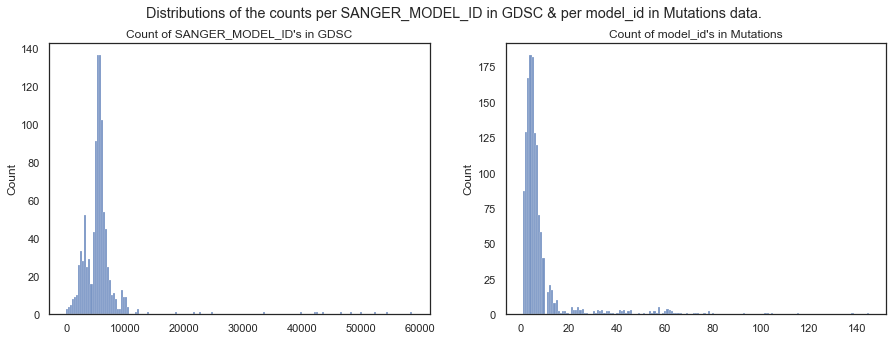

In [74]:
figure, axs = plt.subplots(1, 2, figsize=(15, 5))
figure.suptitle("Distributions of the counts per SANGER_MODEL_ID in GDSC & per model_id in Mutations data.")

sns.histplot(sanger_ids_count_gdsc, ax=axs[0]);
axs[0].set_title("Count of SANGER_MODEL_ID's in GDSC");
sns.histplot(model_ids_count_mut, ax=axs[1]);
axs[1].set_title("Count of model_id's in Mutations");


## Map Gene Expression to Mutations

As in notebook `02_GDSC_map_GeneExpr.ipynb` we saved the sparsed gene expression data to `geneexpr_sparse.pkl`. We will use this tables index column `Sample Name` to map it to the `gene_symbol` column of the mutations table.

In [11]:
# Read sparsed gene expression table.
gene_expr_sparse = pd.read_pickle(f'{PATH_TO_SAVE_DATA_TO}geneexpr_sparse.pkl')
print(gene_expr_sparse.shape)
gene_expr_sparse.head(3)

(1018, 908)


Sample Name,TSPAN6,SCYL3,BAD,LAP3,SNX11,CASP10,CFLAR,FKBP4,RBM6,SLC25A13,...,MYCBP,FIS1,IFRD2,NPEPL1,CEBPD,PLEKHM1,MIF,PRAF2,LYN,POLG2
CAL-120,7.632023,3.614794,7.458409,6.453926,4.767457,2.831262,5.463531,8.654218,5.365098,5.682413,...,8.217182,9.344897,8.175046,3.933749,9.340292,6.167946,11.893872,5.060852,5.892532,6.476232
DMS-114,7.548671,4.066887,7.479327,6.742826,5.246301,2.788942,4.662621,9.530892,5.271282,4.724554,...,8.128025,9.122008,7.564726,3.577621,6.056126,5.271099,11.841300,6.515567,4.580184,6.772732
CAL-51,8.712338,3.956230,7.419672,5.655691,4.645800,3.191751,5.519212,7.612684,5.354469,8.167217,...,7.265206,9.567052,7.774788,4.169622,10.182601,5.784561,12.272137,4.815762,6.482469,6.031281


The gene expression table contains 
- $1018$ `CELL_LINE_NAME` (rows)
- $908$ `GENE_SYMBOL` (rows)

In [24]:
gene_symbols_expr = set(np.unique(list(gene_expr_sparse.columns)))
gene_symbols_mut = set(np.unique(mutations_summary.gene_symbol))

print(f"""
    Gene symbols in ...
        ... Gene Expression table : {len(gene_symbols_expr)}
        ... Mutations       table : {len(gene_symbols_mut)}
""")


    Gene symbols in ...
        ... Gene Expression table : 908
        ... Mutations       table : 611



In [33]:
# Transpose the mutations table such that the GENE_SYMBOLs are the columns and the CELL_LINE_NAMES are the indexes of the rows.
# Copy mutations dataset without GENE_ID column and transpose.
mut_v2 = gene_expr_sparse.iloc[:, :].copy().T
mut_v2
# Ignore the first row and make the GEN_SYMBOL names as the new columns. Also make the previous CELL_LINE_NAMES columns as the new row index.
#mut_v2 = mut_v2.rename(columns=mut_v2.iloc[0]).drop(mut_v2.index[0])
#print(mut_v2.shape)
#mut_v2.head(3)

,CAL-120,DMS-114,CAL-51,H2869,H290,A2058,CESS,H2803,H2722,HCC1419,...,LB831-BLC,HC-1,Jurkat,MOG-G-UVW,unknown_cosmic_1659787,JIMT-1,PEO1,PL4,TT,unknown_cosmic_905954.1
Sample Name,,,,,,,,,,,,,,,,,,,,,
TSPAN6,7.632023,7.548671,8.712338,7.797142,7.729268,7.074533,3.285198,6.961606,5.943046,3.455951,...,7.105637,3.236503,3.038892,8.373223,6.932178,8.441628,8.422922,8.089255,3.112333,7.153127
SCYL3,3.614794,4.066887,3.956230,4.063701,4.341500,4.270903,5.968168,3.715033,3.848112,5.560883,...,3.696835,4.624013,4.348524,3.858121,3.947561,4.425849,3.550390,4.443337,4.266828,4.100493
BAD,7.458409,7.479327,7.419672,7.731137,6.998981,6.550210,6.354063,7.940838,7.488690,8.771958,...,7.147962,6.478426,6.919537,6.801096,7.153122,7.234464,7.525257,6.066356,8.185968,4.967268
LAP3,6.453926,6.742826,5.655691,5.259367,4.611395,6.930777,8.560707,7.815915,4.765141,7.593677,...,5.383810,8.591164,6.208059,6.715130,6.530806,5.759933,7.810126,7.182077,5.663629,6.539451
SNX11,4.767457,5.246301,4.645800,4.558836,5.456692,5.099542,7.574348,4.879785,4.842966,7.809379,...,4.755084,6.761799,5.034195,4.958603,4.629068,4.982202,5.037259,4.611973,4.800284,4.967207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PLEKHM1,6.167946,5.271099,5.784561,7.587263,6.479184,5.700915,6.617353,7.687708,7.944761,5.998456,...,6.714959,6.368537,8.252268,6.436644,6.436742,5.551436,5.634834,7.083564,5.776658,6.306988
MIF,11.893872,11.841300,12.272137,12.000410,11.867211,12.621575,11.825283,12.040673,11.509597,12.777104,...,12.286071,12.572595,12.254136,12.588238,12.366026,12.153612,12.265099,11.919307,12.762295,12.985613
PRAF2,5.060852,6.515567,4.815762,4.544863,6.071288,4.777850,3.455981,4.764558,6.151629,3.612488,...,5.314914,2.943601,4.723601,5.769965,5.070665,3.443244,3.293080,2.978125,5.125786,4.404205


In [34]:
mut_v2.index

Index(['TSPAN6', 'SCYL3', 'BAD', 'LAP3', 'SNX11', 'CASP10', 'CFLAR', 'FKBP4',
       'RBM6', 'SLC25A13',
       ...
       'MYCBP', 'FIS1', 'IFRD2', 'NPEPL1', 'CEBPD', 'PLEKHM1', 'MIF', 'PRAF2',
       'LYN', 'POLG2'],
      dtype='object', name='Sample Name', length=908)

In [25]:
# Check if the SANGER_MODEL_ID has 1-1 relationship with the CELL_LINE_NAME.

test = gdsc_ic50_raw_join.merge(mutations_summary,
                                right_on='model_id',
                                left_on='SANGER_MODEL_ID',
                                how='left',
                                suffixes=['_gdsc', '_mut'])
print(f"""
    GDSC : {gdsc_ic50_raw_join.shape}
    mut  : {mutations_summary.shape}

    inner : {test.shape}
""")


    GDSC : (5707271, 35)
    mut  : (11609, 13)

    inner : (53503481, 48)



In [33]:
gdsc_cell_line_names = np.unique(GDSC.CELL_LINE_NAME.values)

In [38]:
len(np.unique(mutations_data.model_id.values))

1385

In [41]:
len(np.unique(GDSC.CELL_LINE_NAME.values))

988

In [25]:
gdsc_cell_line_names[:10]

array(['201T', '22RV1', '23132-87', '42-MG-BA', '451Lu', '5637', '639-V',
       '647-V', '697', '769-P'], dtype=object)

In [32]:
'TP53' in gdsc_cell_line_names

False